# Bias variance Trade-off and Regularisation.

## In this notebook we will discuss some of the basics of overfitting concepts and how to avoid them using solutions  such as L2 regularisation , Early stopping , adding noise to trainning data etc.

### Setup

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import tqdm_notebook 
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import load_iris

from numpy.linalg import norm

import warnings
warnings.filterwarnings('ignore')


In [22]:
# for better visualization.
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

In [23]:
np.random.seed(0)

## Generate data

In [24]:
iris=load_iris()
# take only the first two features as we want to make the model more complex. If we take all the 4 features it will be 
# very easy multiclass classification problem.
data = iris.data[:, :2]  
labels = iris.target

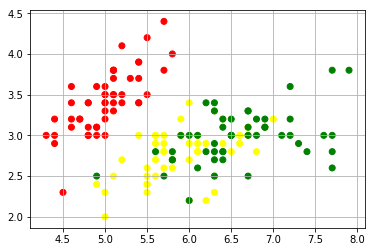

In [25]:
# plotting the features
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.grid()
plt.show()

In [26]:
print("Data shape",data.shape)
print("Labels shape",labels.shape)

Data shape (150, 2)
Labels shape (150,)


## Multi class classification

In [27]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify=labels, random_state=0,test_size=0.2)
print(X_train.shape, X_val.shape, labels.shape)

(120, 2) (30, 2) (150,)


In [28]:
# OneHotEncoding will create a vector which will contain 1 at class label and 0 everywhere.
enc = OneHotEncoder()
y_OH_train = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
y_OH_val = enc.fit_transform(np.expand_dims(Y_val,1)).toarray()
print(y_OH_train.shape, y_OH_val.shape)

(120, 3) (30, 3)


## FF Class

In [29]:
# Note :  some of the code in this block have been taken from stackOverflow and other sources.


# This is our feed Forward class which contains one input layer (that takes 2 inputs )and output layer
# (that produces 3 outputs) and one hidden layer in which we can choose how many neurons to place.
# The class supports diffrent initilization methods such as He , Xavier etc and diffrent activation
# functions.

class FFNetwork:
  
  def __init__(self, num_hidden=2, init_method = 'xavier', activation_function = 'sigmoid', leaky_slope = 0.1):
        
    self.params={}
    self.num_layers=2
    self.layer_sizes = [2, num_hidden, 3]
    self.activation_function = activation_function
    self.leaky_slope = leaky_slope
    np.random.seed(0)
    
    if init_method == "random":
      for i in range(1,self.num_layers+1):
        self.params["W"+str(i)] = np.random.randn(self.layer_sizes[i-1],self.layer_sizes[i])
        self.params["B"+str(i)] = np.random.randn(1,self.layer_sizes[i])
        
    elif init_method == "he":
      for i in range(1,self.num_layers+1):
        self.params["W"+str(i)] = np.random.randn(self.layer_sizes[i-1],self.layer_sizes[i])*np.sqrt(2/self.layer_sizes[i-1])
        self.params["B"+str(i)] = np.random.randn(1,self.layer_sizes[i])
        
    elif init_method == "xavier":
      for i in range(1,self.num_layers+1):
        self.params["W"+str(i)]=np.random.randn(self.layer_sizes[i-1],self.layer_sizes[i])*np.sqrt(1/self.layer_sizes[i-1])
        self.params["B"+str(i)]=np.random.randn(1,self.layer_sizes[i])
    
    self.gradients={}
    self.update_params={}
    self.prev_update_params={}
    for i in range(1,self.num_layers+1):
      self.update_params["v_w"+str(i)]=0
      self.update_params["v_b"+str(i)]=0
      self.update_params["m_b"+str(i)]=0
      self.update_params["m_w"+str(i)]=0
      self.prev_update_params["v_w"+str(i)]=0
      self.prev_update_params["v_b"+str(i)]=0
  
  def forward_activation(self, X): 
    if self.activation_function == "sigmoid":
      return 1.0/(1.0 + np.exp(-X))
    elif self.activation_function == "tanh":
      return np.tanh(X)
    elif self.activation_function == "relu":
      return np.maximum(0,X)
    elif self.activation_function == "leaky_relu":
      return np.maximum(self.leaky_slope*X,X)
      
  def grad_activation(self, X):
    if self.activation_function == "sigmoid":
      return X*(1-X) 
    elif self.activation_function == "tanh":
      return (1-np.square(X))
    elif self.activation_function == "relu":
      return 1.0*(X>0)
    elif self.activation_function == "leaky_relu":
      d=np.zeros_like(X)
      d[X<=0]=self.leaky_slope
      d[X>0]=1
      return d
    
  def get_accuracy(self):    
    Y_pred_train = model.predict(X_train)
    Y_pred_train = np.argmax(Y_pred_train,1)
    Y_pred_val = model.predict(X_val)
    Y_pred_val = np.argmax(Y_pred_val,1)
    accuracy_train = accuracy_score(Y_pred_train, Y_train)
    accuracy_val = accuracy_score(Y_pred_val, Y_val)
    return accuracy_train,accuracy_val
    
  def softmax(self, X):
    exps = np.exp(X)
    return exps / np.sum(exps, axis=1).reshape(-1,1)
  
  def forward_pass(self, X, params = None):
    if params is None:
        params = self.params
    self.A1 = np.matmul(X, params["W1"]) + params["B1"] # (N, 2) * (2, 2) -> (N, 2)
    self.H1 = self.forward_activation(self.A1) # (N, 2)
    self.A2 = np.matmul(self.H1, params["W2"]) + params["B2"] # (N, 2) * (2, 2) -> (N, 2)
    self.H2 = self.softmax(self.A2) # (N, 2)
    return self.H2
  
  def grad(self, X, Y, params = None):
    if params is None:
      params = self.params 
      
    self.forward_pass(X, params)
    m = X.shape[0]
    self.gradients["dA2"] = self.H2 - Y # (N, 4) - (N, 4) -> (N, 4)
    self.gradients["dW2"] = np.matmul(self.H1.T, self.gradients["dA2"]) # (2, N) * (N, 4) -> (2, 4)
    self.gradients["dB2"] = np.sum(self.gradients["dA2"], axis=0).reshape(1, -1) # (N, 4) -> (1, 4)
    self.gradients["dH1"] = np.matmul(self.gradients["dA2"], params["W2"].T) # (N, 4) * (4, 2) -> (N, 2)
    self.gradients["dA1"] = np.multiply(self.gradients["dH1"], self.grad_activation(self.H1)) # (N, 2) .* (N, 2) -> (N, 2)
    self.gradients["dW1"] = np.matmul(X.T, self.gradients["dA1"]) # (2, N) * (N, 2) -> (2, 2)
    self.gradients["dB1"] = np.sum(self.gradients["dA1"], axis=0).reshape(1, -1) # (N, 2) -> (1, 2)
    
  def fit(self, X, Y, epochs=1, algo= "GD",l2_norm=False, lambda_val=0.8, display_loss=False, eta=1):
    train_accuracies={}
    val_accuracies={}
    if display_loss:
      loss = []
      weight_mag = []
    for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      m = X.shape[0]
      
      self.grad(X, Y)
      for i in range(1,self.num_layers+1):
        if l2_norm:
          self.params["W"+str(i)] -= (eta * lambda_val)/m * self.params["W"+str(i)] + eta * (self.gradients["dW"+str(i)]/m)
        else:
          self.params["W"+str(i)] -= eta * (self.gradients["dW"+str(i)]/m)
        self.params["B"+str(i)] -= eta * (self.gradients["dB"+str(i)]/m)
          
      train_accuracy,val_accuracy=self.get_accuracy()
      train_accuracies[num_epoch]=train_accuracy
      val_accuracies[num_epoch]=val_accuracy
      if display_loss:
        Y_pred = self.predict(X)
        loss.append(log_loss(np.argmax(Y, axis=1), Y_pred))
        weight_mag.append((norm(self.params["W1"]) + norm(self.params["W2"]) + norm(self.params["B1"]) + norm(self.params["B2"]))/18)
        
    plt.plot(train_accuracies.values(),label="Train accuracy")
    plt.plot(val_accuracies.values(),label="Validation accuracy")
    plt.plot(np.ones((epochs, 1))*0.9)
    plt.plot(np.ones((epochs, 1))*0.33)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    if display_loss:
      fig, ax1 = plt.subplots()
      color = 'tab:red'
      ax1.set_xlabel('epochs')
      ax1.set_ylabel('Log Loss', color=color)
      ax1.plot(loss, '-o', color=color)
      ax1.tick_params(axis='y', labelcolor=color)
      ax2 = ax1.twinx()  
      color = 'tab:blue'
      ax2.set_ylabel('Weight Magnitude', color=color)  # we already handled the x-label with ax1
      ax2.plot(weight_mag, '-*', color=color)
      ax2.tick_params(axis='y', labelcolor=color)
      fig.tight_layout()  
      plt.show()

  
  def predict(self, X):
    Y_pred = self.forward_pass(X)
    return np.array(Y_pred).squeeze()                               

In [30]:
def print_accuracy():    
    Y_pred_train = model.predict(X_train)
    Y_pred_train = np.argmax(Y_pred_train,1)
    Y_pred_val = model.predict(X_val)
    Y_pred_val = np.argmax(Y_pred_val,1)
    accuracy_train = accuracy_score(Y_pred_train, Y_train)
    accuracy_val = accuracy_score(Y_pred_val, Y_val)
    print("Training accuracy", round(accuracy_train, 4))
    print("Validation accuracy", round(accuracy_val, 4))
    
    if False:
      plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_train, cmap=my_cmap, s=15*(np.abs(np.sign(Y_pred_train-Y_train))+.1))
      plt.show()

# Bias variance tradeoff problem :
###  In simple words according to me high-bias is situation which occurs when both the tranning as well as validation error is very high.Which means our model is not good enough.To solve this problem of high - bias we can do 2 things which are more popular i.e Increase the  model complexity and train the model for more epochs.
### High variance is problem that arises when we have low tranning error and high validation error , this is the typical problem with deep neural networks that they tends to remember the tranning data.To solve this problem we can do diffrent things such as : 
1. add more tranning data(using data augmentation)
2. use regularization
3. do early dropping

## Experiments : 


### 1. only 1 neuron in the hidden layers.Fairly simple model.

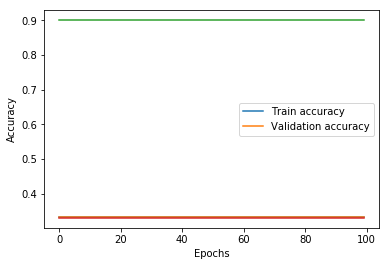

Training accuracy 0.3333
Validation accuracy 0.3333


In [31]:
model = FFNetwork(num_hidden=1) 
model.fit(X_train, y_OH_train, epochs=100, eta=0.1)
print_accuracy()

### Observation : 
1. very high bias , our model is not able to fit the data.
2. To solve the problem of high bias we can make our model a little complex by adding more neurons in the hidden layers.

### 2. adding more neurons to the hidden layer.

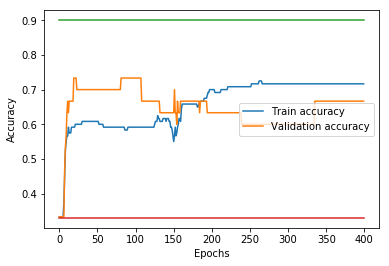

Training accuracy 0.7167
Validation accuracy 0.6667


In [32]:
model = FFNetwork(num_hidden=4) 
model.fit(X_train, y_OH_train, epochs=400, eta=0.25, display_loss=False)
print_accuracy()

### Observation : 
- Reduction in bias as we make our model more complex.

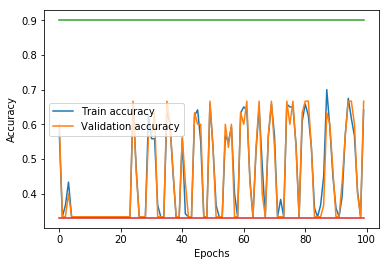

Training accuracy 0.6417
Validation accuracy 0.6667


In [33]:
# we are keeping the model complexity but increasing the learning rate.
model = FFNetwork(num_hidden=4)
model.fit(X_train, y_OH_train, epochs=100, eta=1, display_loss=False)
print_accuracy()

### Observation : 
- There is a fluctuation in the tranning which is not a good thing to have.So we should keep the learning rate low as we increase the model complexity.

### 3. Making the model more complex , tranning for longer i.e adding more epochs and decreasing the learning rate

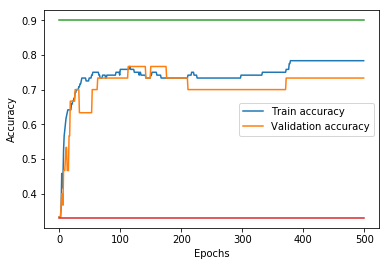

Training accuracy 0.7833
Validation accuracy 0.7333


In [34]:
model = FFNetwork(num_hidden=8)
model.fit(X_train, y_OH_train, epochs=500, eta=0.2, display_loss=False)
print_accuracy()

### Observation : 
- A better model which has less bias.can we decrease the bias even more ?

### 4. Increasing the model complexity to decrease the bias even more . Increasing the tranning time also.

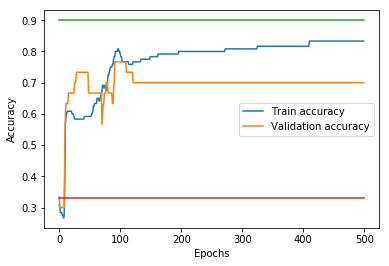

Training accuracy 0.8333
Validation accuracy 0.7


In [35]:
model = FFNetwork(num_hidden=32)
model.fit(X_train, y_OH_train, epochs=500, eta=0.2, display_loss=False)
print_accuracy()

### Observation : 
- Here we can see that we have actually solved the problem of bias but the problem variance has started.Our validation accuracy is not increasing anymore.As a matter of fact it will become worse if we keep increasing the model complexity i.e try to overfit the tranning data.

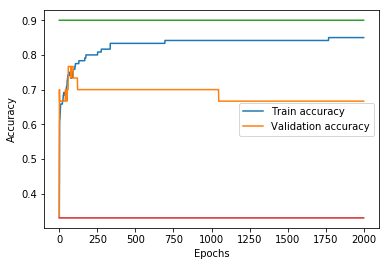

Training accuracy 0.85
Validation accuracy 0.6667


In [36]:
model = FFNetwork(num_hidden=64)
model.fit(X_train, y_OH_train, epochs=2000, eta=0.1, l2_norm=False)
print_accuracy()

## Adding  L2 Regularization to solve the problem of high variance.
## L2 Regularization : 
- we are basically adding a cap for how much the weights can increase , such that the model does not overfit the tranning data. 
## we will slowly increase the lambda_val which represents how much Regularization we want to add.

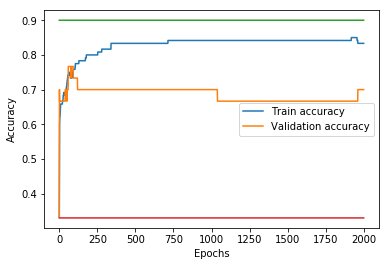

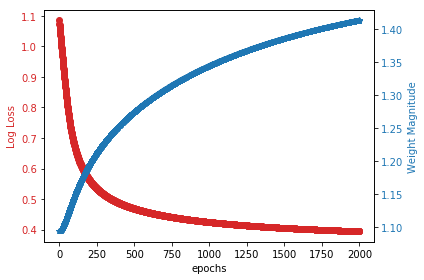

Training accuracy 0.8333
Validation accuracy 0.7


In [37]:
model = FFNetwork(num_hidden=64)
model.fit(X_train, y_OH_train, epochs=2000, eta=0.1, l2_norm=True, lambda_val=0.1, display_loss=True)
print_accuracy()

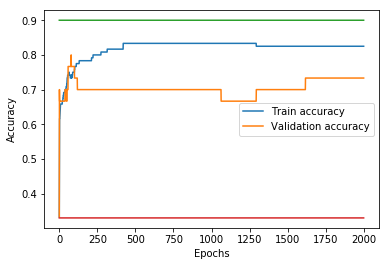

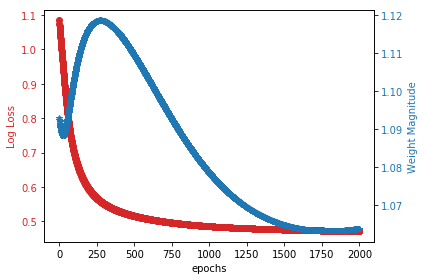

Training accuracy 0.825
Validation accuracy 0.7333


In [38]:
model = FFNetwork(num_hidden=64)
model.fit(X_train, y_OH_train, epochs=2000, eta=0.1, l2_norm=True, lambda_val=1, display_loss=True)
print_accuracy()

### Observation : 
- The above setting is probably the best trade-off that we can have between bias and variance.

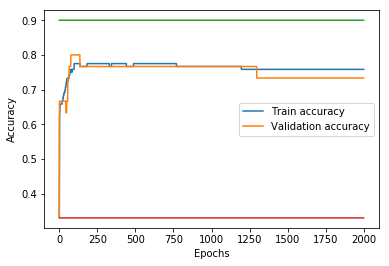

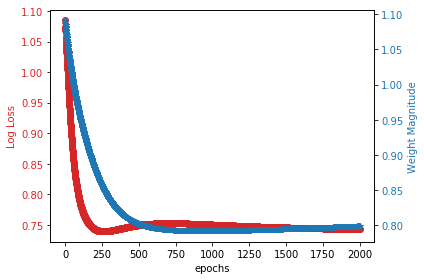

Training accuracy 0.7583
Validation accuracy 0.7333


In [39]:
model = FFNetwork(num_hidden=64)
model.fit(X_train, y_OH_train, epochs=2000, eta=0.1, l2_norm=True, lambda_val=5, display_loss=True)
print_accuracy()

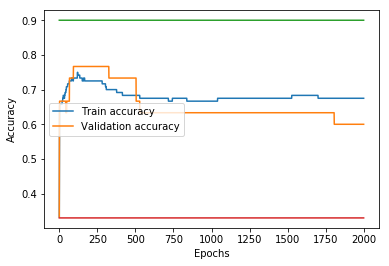

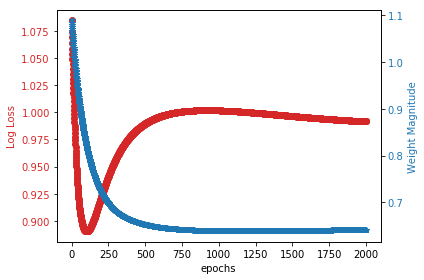

Training accuracy 0.675
Validation accuracy 0.6


In [40]:
model = FFNetwork(num_hidden=64)
model.fit(X_train, y_OH_train, epochs=2000, eta=0.1, l2_norm=True, lambda_val=10, display_loss=True)
print_accuracy()


## Add noise to training data set
- In this method we actully add some noise i.e some change in the value of the feature by some fraction.
- This method can actually work if we set the noise fraction correctly.
- We will try out diffrent noise fraction to see which works.

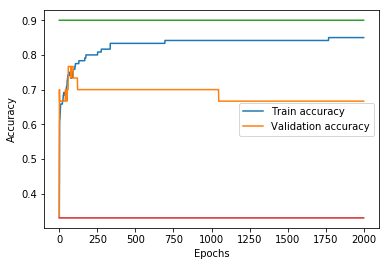

Training accuracy 0.85
Validation accuracy 0.6667


In [41]:
# before adding noise the performance of the model : 
model = FFNetwork(num_hidden=64)
model.fit(X_train, y_OH_train, epochs=2000, eta=0.1, l2_norm=False)
print_accuracy()

0.01


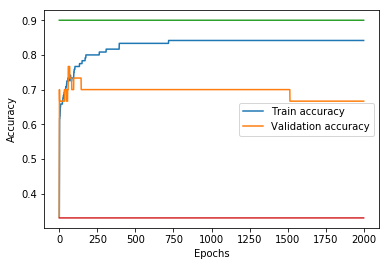

Training accuracy 0.8417
Validation accuracy 0.6667
0.05


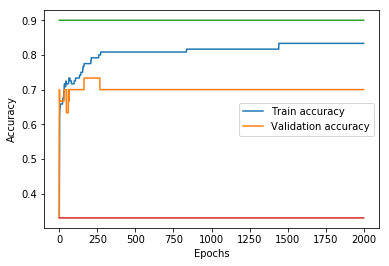

Training accuracy 0.8333
Validation accuracy 0.7
0.1


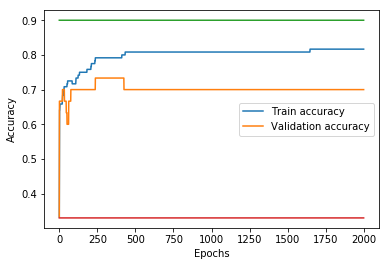

Training accuracy 0.8167
Validation accuracy 0.7
0.15


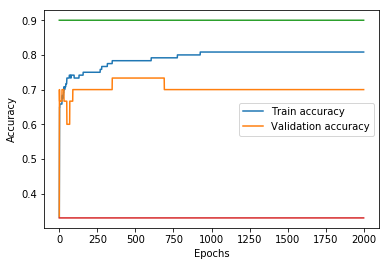

Training accuracy 0.8083
Validation accuracy 0.7
0.18


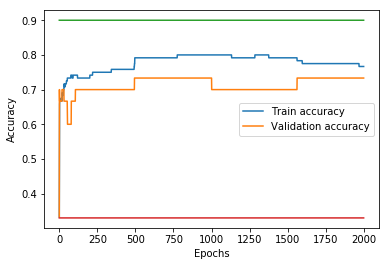

Training accuracy 0.7667
Validation accuracy 0.7333
0.2


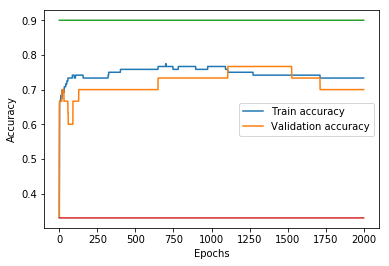

Training accuracy 0.7333
Validation accuracy 0.7


In [42]:
for noise_fraction in [0.01, 0.05, 0.1, 0.15, 0.18, 0.2]:
  print(noise_fraction)
  X_train_noisy = X_train * (1 - noise_fraction*np.random.randn(X_train.shape[0], X_train.shape[1]))
  model = FFNetwork(num_hidden=64)
  model.fit(X_train_noisy, y_OH_train, epochs=2000, eta=0.1, l2_norm=False)
  print_accuracy()

## Early stopping
- In this technique we actually save the models at diffrent checkpoints at the time of tranning and observe at what point the model was performing better , if the model performs better after trannig for 100 epochs say then why waste the computation power as well decrease the model performance for tranning it for 500 epochs or more.


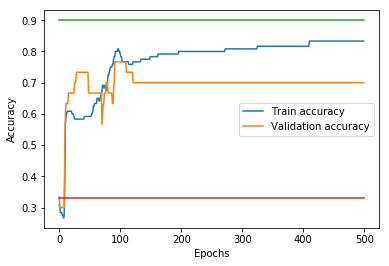

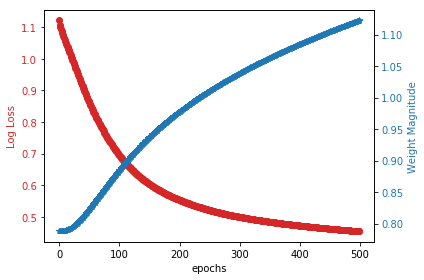

Training accuracy 0.8333
Validation accuracy 0.7


In [43]:
model = FFNetwork(num_hidden=32)
model.fit(X_train, y_OH_train, epochs=500, eta=0.2, display_loss=True)
print_accuracy()

## Tranning the model for only 100 epochs.

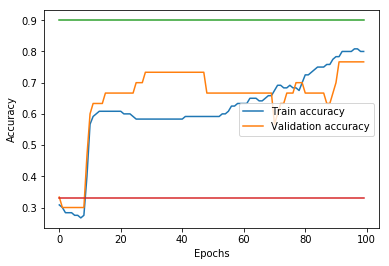

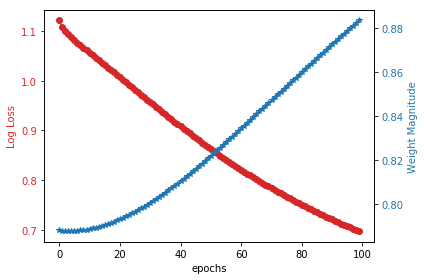

Training accuracy 0.8
Validation accuracy 0.7667


In [44]:
model = FFNetwork(num_hidden=32)
model.fit(X_train, y_OH_train, epochs=100, eta=0.2, display_loss=True)
print_accuracy()

## Obsevations:
* as we can see we are getting much better acuuracy with only 100 epochs.